Stats for es: 0.01128901562 0.00577885831362
Stats for zcr: 0.213715139043 0.239827221723
Utterance:  298 ['ENTER', 'ONE', 'FORTY', 'TWO']


C:\Users\theye\Anaconda3\envs\ml_project\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


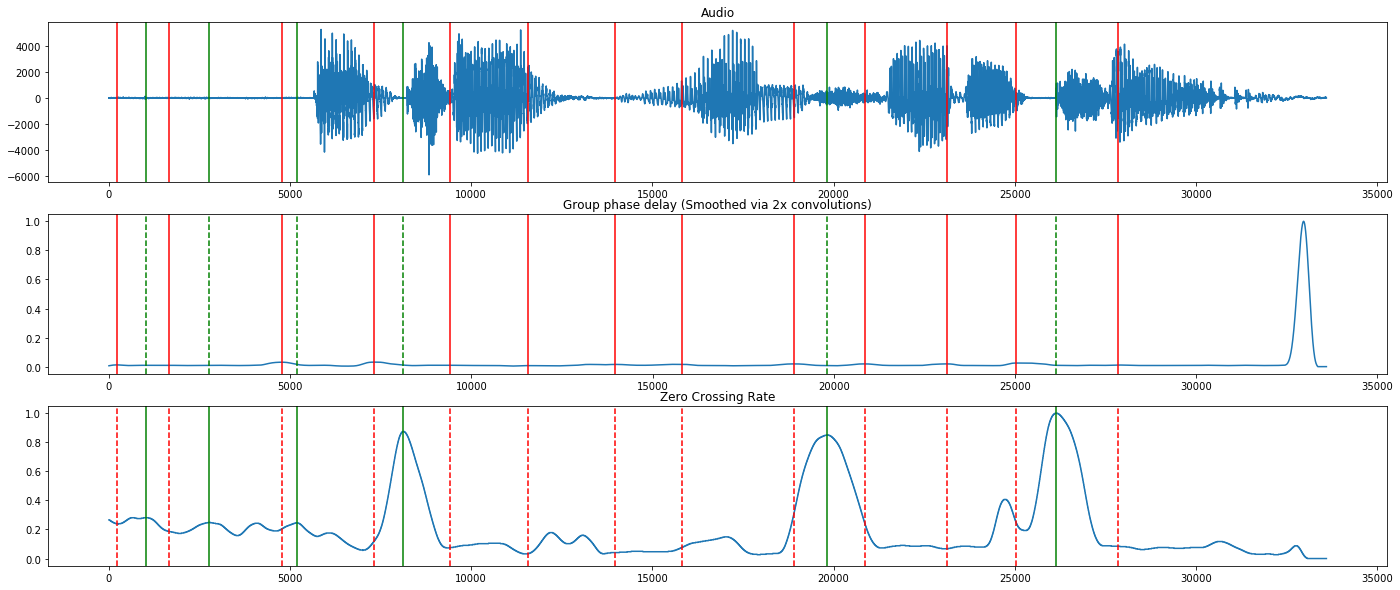

In [2]:
from scipy.signal import chebwin, hamming, savgol_filter, hilbert
from scipy.io import wavfile
from listen.audio.segmentation import segments
import IPython.display
# from listen.spectrogram.spectrogram import Spectrogram
%matplotlib inline
# from listen.data.librispeech import librispeech
from listen.data.an4 import an4
import matplotlib.pyplot as plt
import numpy as np
import random
import peakutils
from peakutils.plot import plot as pplot
from scipy.signal import find_peaks_cwt

an4data = an4.AN4(conversion=False, debug=False)

# spg = Spectrogram(fft_size=2048, step_size=128, thresh=400)
# Milliseconds
min_duration = 30
train = list(an4data.trainset)
ch = random.choice(range(len(train)))
samples, t = train[ch]
# samples,t = librispeech.load_data(dev=True)[15]
# samples = 'D:\\theyenaman\\Dropbox\\code\\python\\ml_project\\listen\\data\\librispeech\\LibriSpeech\\dev-clean\\84\\121123\\84-121123-0020.wav'
rate, data = wavfile.read(samples)
zcr = np.zeros_like(data)
wsize = (rate * min_duration) // 1000

for i in range(len(zcr) - wsize - 1):
    zcr[i] = np.sum(np.abs(np.sign(data[i:i+wsize]) - np.sign(data[i+1:i+wsize+1])))

    
window = hamming(wsize)
# Smooth zcr
for i in range(len(zcr) - wsize):
    zcr[i] = np.mean(zcr[i:i+wsize] * window)

es = segments(data, rate, min_duration=min_duration, alpha=0.96)

es[np.isnan(es)] = 0

es = es / np.max(es)
zcr = zcr / np.max(zcr)

# Estimate data baseline
l = len(es) // 10
r = 9 * l

me = np.max(es)
be = np.mean(es[l:r]) / me
se = np.std(es[l:r]) / me

mz = np.max(zcr)
bz = np.mean(zcr[l:r]) / mz
sz = np.std(zcr[l:r]) / mz

print("Stats for es:", be, se)
print("Stats for zcr:", bz, sz)
print("Utterance: ", ch, t)
indices = peakutils.indexes(es[:r], min_dist=3*wsize, thres=be)
zcidx = peakutils.indexes(zcr[:r], min_dist=3*wsize, thres=bz)

fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(24, 10))
ax[0].plot(data)
ax[0].set_title('Audio')
ax[1].plot(es)
ax[1].set_title('Group phase delay (Smoothed via 2x convolutions)')
ax[2].plot(zcr)
ax[2].set_title('Zero Crossing Rate')

for idx in indices:
    ax[0].axvline(x=idx, color='red')
    ax[1].axvline(x=idx, color='red')
    ax[2].axvline(x=idx, color='red', linestyle='dashed')
for idx in zcidx:
    ax[0].axvline(x=idx, color='green')
    ax[1].axvline(x=idx, color='green', linestyle='dashed')
    ax[2].axvline(x=idx, color='green')

plt.legend()
plt.show()
IPython.display.Audio(data=data, rate=rate)